In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import time
import pickle as pk
import matplotlib.pyplot as plt
import json
from glob import glob

# Definições iniciais

## Initializing Constants

In [2]:
# Opening JSON file
with open("control_dicts/constant_properties.json", "r") as openfile:
    # Reading from json file
    constant_properties = json.load(openfile)

Db = constant_properties["Db"]
Dn = constant_properties["Dn"]
phi = constant_properties["phi"]
cb = constant_properties["cb"]
lambd_nb = constant_properties["lambd_nb"]
mi_n = constant_properties["mi_n"]
lambd_bn = constant_properties["lambd_bn"]
y_n = constant_properties["y_n"]
Cn_max = constant_properties["Cn_max"]
X_nb = constant_properties["X_nb"]
central_ini_cond = constant_properties["central_ini_cond"]
ini_cond_var = constant_properties["ini_cond_var"]

# Opening JSON file
with open("control_dicts/mesh_properties.json", "r") as openfile:
    # Reading from json file
    mesh_properties = json.load(openfile)

h = mesh_properties["h"]
k = mesh_properties["k"]
x_dom = mesh_properties["x_dom"]
y_dom = mesh_properties["y_dom"]
t_dom = mesh_properties["t_dom"]

## Reading results file

In [3]:
def get_infection_site(struct_name):

    center_str = (struct_name).split("__")[-2].split("(")[-1].split(")")[0].split(",")

    center = (float(center_str[0]), float(center_str[1]))

    radius = float(struct_name.split("__")[-1].split("--")[-1].split(".pkl")[0])

    return center, radius


def read_files(path):
    file_list = sorted(glob(path + "/*"))

    speed_up_list = []
    Cb_list = []
    Cn_list = []

    for file in file_list:

        variable = lambda a: a.split("/")[-1].split("__")[0]

        if variable(file) == "Cl":
            Cn_list.append(file)

        elif variable(file) == "Cp":
            Cb_list.append(file)

        elif variable(file) == "speed_up":
            speed_up_list.append(file)

    return Cn_list, Cb_list, speed_up_list


def change_dim_order(np_array):
    # (2, 2, 100001, 21, 21)
    sim_shape = np_array.shape

    form_array = np.zeros(
        (
            sim_shape[2],
            sim_shape[0],
            sim_shape[1],
            sim_shape[3],
            sim_shape[4],
        )
    )

    for i in range(sim_shape[2]):
        form_array[i, :, :, :, :] = np_array[:, :, i, :, :]

    return form_array


def format_array(Cb_list, Cn_list):

    for i, (Cb_file, Cn_file) in enumerate(zip(Cb_list, Cn_list)):
        with open(Cb_file, "rb") as f:
            new_Cb = pk.load(f)

        with open(Cn_file, "rb") as f:
            new_Cn = pk.load(f)

        sim_shape = new_Cb.shape

        if i == 0:
            Cb = np.zeros(
                (len(Cb_list), sim_shape[0], sim_shape[1], sim_shape[2], sim_shape[3])
            )

            Cn = np.zeros(
                (len(Cn_list), sim_shape[0], sim_shape[1], sim_shape[2], sim_shape[3])
            )

            center_x = np.zeros(len(Cb_list))

            center_y = np.zeros(len(Cb_list))

            radius_array = np.zeros(len(Cb_list))

        Cb[i, :, :, :, :] = new_Cb

        Cn[i, :, :, :, :] = new_Cn

        center, radius = get_infection_site(Cb_file)

        center_x[i], center_y[i] = center

        radius_array[i] = radius

    return Cb, Cn, center_x, center_y, radius_array


Cn_list, Cb_list, speed_up_list = read_files("fvm_sim")

Cb_fvm, Cn_fvm, center_x_array, center_y_array, radius_array = format_array(
    Cb_list[:1], Cn_list[:1]
)

## Formatting input parameters

In [4]:
def get_mesh_properties(
    x_dom,
    y_dom,
    t_dom,
    h,
    k,
    central_ini_cond,
    ini_cond_var,
    n_ini,
    verbose=True,
):

    size_x = int(((x_dom[1] - x_dom[0]) / (h)))
    size_y = int(((y_dom[1] - y_dom[0]) / (h)))
    size_t = int(((t_dom[1] - t_dom[0]) / (k)) + 1)

    initial_cond = np.linspace(
        central_ini_cond * (1 - ini_cond_var),
        central_ini_cond * (1 + ini_cond_var),
        num=n_ini,
        endpoint=True,
        dtype=np.float16,
    )

    if verbose:
        print(
            "Steps in time = {:d}\nSteps in space_x = {:d}\nSteps in space_y = {:d}\n".format(
                size_t,
                size_x,
                size_y,
            )
        )

    return (size_x, size_y, size_t, initial_cond)


size_x, size_y, size_t, initial_cond = get_mesh_properties(
    x_dom, y_dom, t_dom, h, k, central_ini_cond, ini_cond_var, Cb_fvm.shape[1]
)

Steps in time = 10001
Steps in space_x = 20
Steps in space_y = 20



In [5]:
def create_input_mesh(
    t_dom,
    x_dom,
    y_dom,
    size_t,
    size_x,
    size_y,
    center_x_array,
    center_y_array,
    initial_cond,
    radius_array,
):
    t_np = np.linspace(t_dom[0], t_dom[1], num=size_t, endpoint=False, dtype=np.float32)
    x_np = np.linspace(x_dom[0], x_dom[1], num=size_x, endpoint=False, dtype=np.float32)
    y_np = np.linspace(y_dom[0], y_dom[1], num=size_y, endpoint=False, dtype=np.float32)
    infection_idx = np.linspace(
        0, len(center_x_array), num=len(center_x_array), endpoint=False, dtype=np.int32
    )

    # Change first with second dimension for np.meshgrid match with
    # torch.mashgrid and C flattening logic

    initial_mesh, infection_mesh, t_mesh, x_mesh, y_mesh = np.meshgrid(
        initial_cond, infection_idx, t_np, x_np, y_np
    )

    center_x_mesh = np.zeros(infection_mesh.ravel().shape)
    center_y_mesh = np.zeros(infection_mesh.ravel().shape)
    radius_mesh = np.zeros(infection_mesh.ravel().shape)

    for i, idx in enumerate(infection_mesh.ravel()):

        center_x_mesh[i] = center_x_array[idx]
        center_y_mesh[i] = center_y_array[idx]
        radius_mesh[i] = radius_array[idx]

    return (
        initial_mesh,
        center_x_mesh,
        center_y_mesh,
        radius_mesh,
        t_mesh,
        x_mesh,
        y_mesh,
    )

In [6]:
def allocates_training_mesh(
    t_dom,
    x_dom,
    y_dom,
    size_t,
    size_x,
    size_y,
    center_x_array,
    center_y_array,
    initial_cond,
    radius_array,
    Cb_fvm,
    Cn_fvm,
):

    (
        initial_mesh,
        center_x_mesh,
        center_y_mesh,
        radius_mesh,
        t_mesh,
        x_mesh,
        y_mesh,
    ) = create_input_mesh(
        t_dom,
        x_dom,
        y_dom,
        size_t,
        size_x,
        size_y,
        center_x_array,
        center_y_array,
        initial_cond,
        radius_array,
    )

    if torch.cuda.is_available():
        device = torch.device("cuda")

    else:
        device = "cpu"

    print("device:", device)

    initial_tc = (
        torch.tensor(initial_mesh, dtype=torch.float16)
        .reshape(-1, 1)
        .requires_grad_(True)
    )

    center_x_tc = (
        torch.tensor(center_x_mesh, dtype=torch.float16)
        .reshape(-1, 1)
        .requires_grad_(True)
    )

    center_y_tc = (
        torch.tensor(center_y_mesh, dtype=torch.float16)
        .reshape(-1, 1)
        .requires_grad_(True)
    )

    radius_tc = (
        torch.tensor(radius_mesh, dtype=torch.float16)
        .reshape(-1, 1)
        .requires_grad_(True)
    )

    t_tc = (
        torch.tensor(t_mesh, dtype=torch.float16)
        .reshape(-1, 1)
        .requires_grad_(True)
    )

    x_tc = (
        torch.tensor(x_mesh, dtype=torch.float16)
        .reshape(-1, 1)
        .requires_grad_(True)
    )

    y_tc = (
        torch.tensor(y_mesh, dtype=torch.float16)
        .reshape(-1, 1)
        .requires_grad_(True)
    )

    target = torch.tensor(
        np.hstack((Cn_fvm.reshape(-1, 1), Cb_fvm.reshape(-1, 1))), dtype=torch.float16
    )

    return (
        initial_tc,
        center_x_tc,
        center_y_tc,
        radius_tc,
        t_tc,
        x_tc,
        y_tc,
        target,
        device,
    )

In [7]:
(initial_tc, center_x_tc, center_y_tc, radius_tc, t_tc, x_tc, y_tc, target, device) = (
    allocates_training_mesh(
        t_dom,
        x_dom,
        y_dom,
        size_t,
        size_x,
        size_y,
        center_x_array,
        center_y_array,
        initial_cond,
        radius_array,
        Cb_fvm,
        Cn_fvm,
    )
)

device: cuda


# Archtecture handling

In [8]:
activation_dict = {
    "Elu": nn.ELU,
    "LeakyReLU": nn.LeakyReLU,
    "Sigmoid": nn.Sigmoid,
    "Softplus": nn.Softplus,
    "Tanh": nn.Tanh,
    "Linear": nn.Linear,
    "ReLU": nn.ReLU,
    "RReLU": nn.RReLU,
    "SELU": nn.SELU,
    "CELU": nn.CELU,
    "GELU": nn.GELU,
    "SiLU": nn.SiLU,
    "GLU": nn.GLU,
}

In [9]:
arch_str = "Tanh--32__Tanh--32__Tanh--32__GELU--32"

In [10]:
def generate_model(arch_str):
    hidden_layers = arch_str.split("__")

    modules = []

    for params in hidden_layers:
        if len(params) != 0:
            activation, out_neurons = params.split("--")

            if len(modules) == 0:
                if activation == "Linear":
                    modules.append(
                        activation_dict[activation](7, int(out_neurons)).half()
                    )

                else:
                    modules.append(nn.Linear(7, int(out_neurons)).half())
                    modules.append(activation_dict[activation]().half())

            else:
                if activation == "Linear":
                    modules.append(
                        activation_dict[activation](
                            int(in_neurons), int(out_neurons)
                        ).half()
                    )

                else:
                    modules.append(nn.Linear(int(in_neurons), int(out_neurons)).half())
                    modules.append(activation_dict[activation]().half())

            in_neurons = out_neurons

    modules.append(nn.Linear(int(in_neurons), 2).half())

    return nn.Sequential(*modules)

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)


In [11]:
model = generate_model(arch_str).to(device).apply(init_weights)

print(model)

Sequential(
  (0): Linear(in_features=7, out_features=32, bias=True)
  (1): Tanh()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): Tanh()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): Tanh()
  (6): Linear(in_features=32, out_features=32, bias=True)
  (7): GELU(approximate='none')
  (8): Linear(in_features=32, out_features=2, bias=True)
)


# PINN

In [12]:
def normalize_torch(dataset):
    with torch.no_grad():
        dt_min = torch.min(dataset, 0).values
        dt_max = torch.max(dataset, 0).values
        normalized = (dataset - dt_min) / (dt_max - dt_min)

    return normalized.requires_grad_(True), dt_min, dt_max

In [13]:
def normalize_data_input(data_input, steps):
    with torch.no_grad():
        dataset = data_input.reshape(steps, steps, 2)
        normalized = torch.zeros_like(dataset)
        for i in range(len(dataset)):
            dt_min = torch.min(dataset[i], 0).values
            dt_max = torch.max(dataset[i], 0).values
            normalized[i] = (dataset[i] - dt_min) / (dt_max - dt_min)

    return normalized.reshape((steps) * (steps), 2)

In [14]:
def rescale(dataset, dt_min, dt_max):
    return (dt_max - dt_min) * dataset + dt_min

In [15]:
def shuffle_data(initial, center_x, center_y, radius, t, x, y, target):
    Data_num = np.arange(x.shape[0])
    np.random.shuffle(Data_num)

    return (
        initial[Data_num],
        center_x[Data_num],
        center_y[Data_num],
        radius[Data_num],
        t[Data_num],
        x[Data_num],
        y[Data_num],
        target[Data_num],
    )

In [16]:
def train_test_split(
    initial,
    center_x,
    center_y,
    radius,
    t,
    x,
    y,
    target,
    device,
    test_size=0.5,
    shuffle=True,
):
    with torch.no_grad():
        if shuffle:
            initial, center_x, center_y, radius, t, x, y, target = shuffle_data(
                initial, center_x, center_y, radius, t, x, y, target
            )
        if test_size < 1:
            train_ratio = len(x) - int(len(x) * test_size)
            initial_train, initial_test = initial[:train_ratio], initial[train_ratio:]
            center_x_train, center_x_test = (
                center_x[:train_ratio],
                center_x[train_ratio:],
            )
            center_y_train, center_y_test = (
                center_y[:train_ratio],
                center_y[train_ratio:],
            )
            radius_train, radius_test = radius[:train_ratio], radius[train_ratio:]
            t_train, t_test = t[:train_ratio], t[train_ratio:]
            x_train, x_test = x[:train_ratio], x[train_ratio:]
            y_train, y_test = y[:train_ratio], y[train_ratio:]
            target_train, target_test = target[:train_ratio], target[train_ratio:]
            return (
                initial_train.requires_grad_(True).to(device),
                initial_test.requires_grad_(True).to(device),
                center_x_train.requires_grad_(True).to(device),
                center_x_test.requires_grad_(True).to(device),
                center_y_train.requires_grad_(True).to(device),
                center_y_test.requires_grad_(True).to(device),
                radius_train.requires_grad_(True).to(device),
                radius_test.requires_grad_(True).to(device),
                t_train.requires_grad_(True).to(device),
                t_test.requires_grad_(True).to(device),
                x_train.requires_grad_(True).to(device),
                x_test.requires_grad_(True).to(device),
                y_train.requires_grad_(True).to(device),
                y_test.requires_grad_(True).to(device),
                target_train.requires_grad_(True).to(device),
                target_test.requires_grad_(True).to(device),
            )
        elif test_size in range(1, len(x)):
            initial_train, initial_test = initial[test_size:], initial[:test_size]
            center_x_train, center_x_test = (
                center_x[test_size:],
                center_x[:test_size],
            )
            center_y_train, center_y_test = (
                center_y[test_size:],
                center_y[:test_size],
            )
            radius_train, radius_test = radius[test_size:], radius[:test_size]
            t_train, t_test = t[test_size:], t[:test_size]
            x_train, x_test = x[test_size:], x[:test_size]
            y_train, y_test = y[test_size:], y[:test_size]
            target_train, target_test = target[test_size:], target[:test_size]
            return (
                initial_train.requires_grad_(True).to(device),
                initial_test.requires_grad_(True).to(device),
                center_x_train.requires_grad_(True).to(device),
                center_x_test.requires_grad_(True).to(device),
                center_y_train.requires_grad_(True).to(device),
                center_y_test.requires_grad_(True).to(device),
                radius_train.requires_grad_(True).to(device),
                radius_test.requires_grad_(True).to(device),
                t_train.requires_grad_(True).to(device),
                t_test.requires_grad_(True).to(device),
                x_train.requires_grad_(True).to(device),
                x_test.requires_grad_(True).to(device),
                y_train.requires_grad_(True).to(device),
                y_test.requires_grad_(True).to(device),
                target_train.requires_grad_(True).to(device),
                target_test.requires_grad_(True).to(device),
            )

In [17]:
def generate_training_points(num_points):
    initial = torch.rand(num_points, 1, dtype=torch.float16) * (0.6 - 0.4) + 0.4
    center_x = torch.rand(num_points, 1, dtype=torch.float16)
    center_y = torch.rand(num_points, 1, dtype=torch.float16)
    radius = torch.rand(num_points, 1, dtype=torch.float16) * (0.2 - 0.1) + 0.1
    t = torch.rand(num_points, 1, dtype=torch.float16) * 10
    x = torch.rand(num_points, 1, dtype=torch.float16)
    y = torch.rand(num_points, 1, dtype=torch.float16)

    return (
        initial.requires_grad_(True).to(device),
        center_x.requires_grad_(True).to(device),
        center_y.requires_grad_(True).to(device),
        radius.requires_grad_(True).to(device),
        t.requires_grad_(True).to(device),
        x.requires_grad_(True).to(device),
        y.requires_grad_(True).to(device),
    )

In [18]:
def generate_boundary_points(num_points):
    x_boundary = torch.tensor([0.0, 1], dtype=torch.float16).repeat(num_points // 2, 1)
    y_boundary = torch.rand(num_points, dtype=torch.float16)

    if torch.rand(1) > 0.5:
        x_boundary, y_boundary = y_boundary, x_boundary
        n = torch.tensor([[0.0, -1.0], [0.0, 1.0]], dtype=torch.float16).repeat(
            num_points // 2, 1
        )
    else:
        n = torch.tensor([[-1.0, 0.0], [1.0, 0.0]], dtype=torch.float16).repeat(
            num_points // 2, 1
        )

    return (
        x_boundary.view(-1, 1).requires_grad_(True).to(device),
        y_boundary.view(-1, 1).requires_grad_(True).to(device),
        n.requires_grad_(True).to(device),
    )

In [19]:
def initial_condition_points(data_input):

    initial_tc = data_input[:,0]
    center_x_tc= data_input[:,1]
    center_y_tc= data_input[:,2]
    radius_tc= data_input[:,3]
    x_tc= data_input[:,5]
    y_tc= data_input[:,6]

    # Calculate squared distances from each point to the circle centers
    squared_distances = (x_tc - center_x_tc) ** 2 + (y_tc - center_y_tc) ** 2

    # Create a mask for points inside the circle
    inside_circle_mask = squared_distances <= radius_tc**2

    # Initialize the tensor and set the values for points inside the circle
    C_init = torch.zeros((len(x_tc), 2),dtype=torch.float16)
    C_init[:, 1] = inside_circle_mask.ravel() * initial_tc.ravel()

    return C_init

In [20]:
def boundary_condition(
    model, device, initial, center_x, center_y, radius, t_b, x_b, y_b, n, Dn, X_nb, Db
):

    input_boundary = (
        torch.cat(
            [
                initial,
                center_x,
                center_y,
                radius,
                t_b,
                x_b,
                y_b,
            ],
            dim=1,
        )
        .to(device)
        .requires_grad_(True)
    )

    Cp, Cl = model(input_boundary).tensor_split(2, dim=1)

    del input_boundary
    nx, ny = n.tensor_split(2, dim=1)

    if nx[0].item() != 0:
        dCp_dx = torch.autograd.grad(
            Cp,
            x_b,
            grad_outputs=torch.ones_like(Cp),
            create_graph=True,
            retain_graph=True,
        )

        dCl_dx = torch.autograd.grad(
            Cl,
            x_b,
            grad_outputs=torch.ones_like(Cl),
            create_graph=True,
            retain_graph=True,
        )

        Cl_boundary = torch.mul(
            ((Dn * dCl_dx[0]) - X_nb * torch.mul(Cl, dCp_dx[0])), nx
        )

        Cp_boundary = torch.mul((Db * dCp_dx[0]), nx)

        return torch.cat([Cl_boundary, Cp_boundary], dim=1)

    else:
        dCp_dy = torch.autograd.grad(
            Cp,
            y_b,
            grad_outputs=torch.ones_like(Cp),
            create_graph=True,
            retain_graph=True,
        )

        dCl_dy = torch.autograd.grad(
            Cl,
            y_b,
            grad_outputs=torch.ones_like(Cl),
            create_graph=True,
            retain_graph=True,
        )

        Cl_boundary = torch.mul(
            ((Dn * dCl_dy[0]) - X_nb * torch.mul(Cl, dCp_dy[0])), ny
        )

        Cp_boundary = torch.mul((Db * dCp_dy[0]), ny)

        return torch.cat([Cl_boundary, Cp_boundary], dim=1)

In [21]:
def pde(
    model,
    device,
    initial,
    center_x,
    center_y,
    radius,
    t,
    x,
    y,
    cb,
    lambd_nb,
    Db,
    y_n,
    Cn_max,
    lambd_bn,
    mi_n,
    Dn,
    X_nb,
):

    Cl, Cp = model(
        torch.cat(
            [
                initial,
                center_x,
                center_y,
                radius,
                t,
                x,
                y,
            ],
            dim=1,
        )
    ).tensor_split(2, dim=1)

    # Calculating Cp value

    dCp_dx, dCp_dy = torch.autograd.grad(
        Cp,
        [x, y],
        grad_outputs=torch.ones_like(Cp),
        create_graph=True,
        retain_graph=True,
    )

    dCp_dx_2 = torch.autograd.grad(
        dCp_dx,
        x,
        grad_outputs=torch.ones_like(dCp_dx),
        create_graph=True,
        retain_graph=True,
    )[0]

    dCp_dy_2 = torch.autograd.grad(
        dCp_dy,
        y,
        grad_outputs=torch.ones_like(dCp_dy),
        create_graph=True,
        retain_graph=True,
    )[0]

    dCp_dt = torch.autograd.grad(
        Cp,
        t,
        grad_outputs=torch.ones_like(Cp),
        create_graph=True,
        retain_graph=True,
    )[0]

    qb = cb * Cp
    rb = lambd_nb * torch.mul(Cl, Cp)

    Cp_eq = Db * (dCp_dx_2 + dCp_dy_2) - rb + qb - dCp_dt

    # Calculating Cl value

    dCl_dx, dCl_dy = torch.autograd.grad(
        Cl,
        [x, y],
        grad_outputs=torch.ones_like(Cl),
        create_graph=True,
        retain_graph=True,
    )

    dCl_dx_2 = torch.autograd.grad(
        dCl_dx,
        x,
        grad_outputs=torch.ones_like(dCl_dx),
        create_graph=True,
        retain_graph=True,
    )[0]

    dCl_dy_2 = torch.autograd.grad(
        dCl_dy,
        y,
        grad_outputs=torch.ones_like(dCl_dy),
        create_graph=True,
        retain_graph=True,
    )[0]

    dCl_dt = torch.autograd.grad(
        Cl,
        t,
        grad_outputs=torch.ones_like(Cl),
        create_graph=True,
        retain_graph=True,
    )[0]

    qn = y_n * torch.mul(Cp, (Cn_max - Cl))
    rn = lambd_bn * torch.mul(Cl, Cp) + mi_n * Cl

    Cl_eq = (
        Dn * (dCl_dx_2 + dCl_dy_2)
        - X_nb
        * (
            (torch.mul(dCl_dx, dCp_dx) + torch.mul(Cl, dCp_dx_2))
            + (torch.mul(dCl_dy, dCp_dy) + torch.mul(Cl, dCp_dy_2))
        )
        - rn
        + qn
    ) - dCl_dt

    return torch.cat([Cl_eq, Cp_eq], dim=1)

In [22]:
class train:
    def __init__(
        self,
        n_epochs,
        batch_size,
        decay_rate,
        model,
        initial_tc,
        center_x_tc,
        center_y_tc,
        radius_tc,
        t_tc,
        x_tc,
        y_tc,
        target,
        device,
        n_points,
        constant_properties,
        norm_weights=None,
        validation=None,
        tolerance=None,
        patience=10,
    ):

        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.decay_rate = decay_rate
        self.model = model.to(device)
        self.device = device
        self.n_points = n_points
        self.constant_properties = constant_properties
        self.norm_weights = norm_weights
        self.validation = validation
        self.tolerance = tolerance
        self.patience = patience

        for i, inp in enumerate(
            [
                initial_tc,
                center_x_tc,
                center_y_tc,
                radius_tc,
                t_tc,
                x_tc,
                y_tc,
                target,
            ]
        ):
            if torch.isnan(inp).any():
                print("NaN detected in {i}")

        if self.validation:
            (
                self.initial_train,
                self.initial_test,
                self.center_x_train,
                self.center_x_test,
                self.center_y_train,
                self.center_y_test,
                self.radius_train,
                self.radius_test,
                self.t_train,
                self.t_test,
                self.x_train,
                self.x_test,
                self.y_train,
                self.y_test,
                self.target_train,
                self.target_test,
            ) = train_test_split(
                initial_tc,
                center_x_tc,
                center_y_tc,
                radius_tc,
                t_tc,
                x_tc,
                y_tc,
                target,
                device,
                test_size=self.validation,
            )

        else:
            self.initial_train = initial_tc.to(device)
            self.initial_test = None
            self.center_x_train = center_x_tc.to(device)
            self.center_x_test = None
            self.center_y_train = center_y_tc.to(device)
            self.center_y_test = None
            self.radius_train = radius_tc.to(device)
            self.radius_test = None
            self.t_train = t_tc.to(device)
            self.t_test = None
            self.x_train = x_tc.to(device)
            self.x_test = None
            self.y_train = y_tc.to(device)
            self.y_test = None
            self.target_train = target.to(device)
            self.target_test = None

        self.test_data = (
            torch.cat(
                [
                    self.initial_test,
                    self.center_x_test,
                    self.center_y_test,
                    self.radius_test,
                    self.t_test,
                    self.x_test,
                    self.y_test,
                ],
                dim=1,
            )
            .requires_grad_(True)
            .to(device)
        )

        pass

    def loss_func(
        self,
    ):
        self.batch = torch.cat(
            [
                self.initial_train,
                self.center_x_train,
                self.center_y_train,
                self.radius_train,
                self.t_train,
                self.x_train,
                self.y_train,
            ],
            dim=1,
        )[self.i : self.i + self.batch_size, :]

        C_initial_batch = initial_condition_points(self.batch).to(self.device)

        # Computing intial loss
        t_initial = torch.zeros((self.batch.shape[0], 1), dtype=torch.float16).to(
            self.device
        )

        mesh_ini = torch.cat(
            [self.batch[:, :5], t_initial, self.batch[:, 6:]],
            dim=1,
        )

        C_initial_pred = self.model(mesh_ini)

        self.loss_initial = self.criterion(C_initial_batch, C_initial_pred)

        if torch.isnan(self.batch).any():
            print("NaN detected in self.batch")

        if torch.isnan(C_initial_batch).any():
            print("NaN detected in C_initial_batch")

        if torch.isnan(t_initial).any():
            print("NaN detected in t_initial")

        if torch.isnan(mesh_ini).any():
            print("NaN detected in mesh_ini")

        if torch.isnan(C_initial_pred).any():
            print("NaN detected in C_initial_pred")

        if torch.isnan(self.loss_initial).any():
            print("NaN detected in self.loss_initial")


        # Computing pde loss

        initial, center_x, center_y, radius, t, x, y = generate_training_points(
            self.n_points
        )

        predicted_pde = pde(
            self.model,
            self.device,
            initial,
            center_x,
            center_y,
            radius,
            t,
            x,
            y,
            self.constant_properties["cb"],
            self.constant_properties["lambd_nb"],
            self.constant_properties["Db"],
            self.constant_properties["y_n"],
            self.constant_properties["Cn_max"],
            self.constant_properties["lambd_bn"],
            self.constant_properties["mi_n"],
            self.constant_properties["Dn"],
            self.constant_properties["X_nb"],
        )

        self.loss_pde = self.criterion(
            predicted_pde,
            torch.zeros_like(predicted_pde),
        )

        if torch.isnan(initial).any():
            print("NaN detected in initial")

        if torch.isnan(center_x).any():
            print("NaN detected in center_x")

        if torch.isnan(center_y).any():
            print("NaN detected in center_y")

        if torch.isnan(radius).any():
            print("NaN detected in radius")

        if torch.isnan(t).any():
            print("NaN detected in t")

        if torch.isnan(x).any():
            print("NaN detected in x")

        if torch.isnan(y).any():
            print("NaN detected in y")

        if torch.isnan(predicted_pde).any():
            print("NaN detected in predicted_pde")

        if torch.isnan(self.loss_pde).any():
            print("NaN detected in self.loss_pde")
            
        # Computing boundary loss

        x_bnd, y_bnd, n_bnd = generate_boundary_points(self.n_points)

        predicted_boundary = boundary_condition(
            self.model,
            self.device,
            initial,
            center_x,
            center_y,
            radius,
            t,
            x_bnd,
            y_bnd,
            n_bnd,
            self.constant_properties["Dn"],
            self.constant_properties["X_nb"],
            self.constant_properties["Db"],
        )

        self.loss_boundary = self.criterion(
            predicted_boundary,
            torch.zeros_like(predicted_boundary),
        )

        if torch.isnan(initial).any():
            print("NaN detected in initial")
        if torch.isnan(center_x).any():
            print("NaN detected in center_x")
        if torch.isnan(center_y).any():
            print("NaN detected in center_y")
        if torch.isnan(radius).any():
            print("NaN detected in radius")
        if torch.isnan(t).any():
            print("NaN detected in t")
        if torch.isnan(x_bnd).any():
            print("NaN detected in x_bnd")
        if torch.isnan(y_bnd).any():
            print("NaN detected in y_bnd")


        # Computing data loss

        C_pred = self.model(self.batch.to(device))

        self.loss_data = self.criterion(
            C_pred, self.target_train[self.i : self.i + self.batch_size, :]
        )

        if torch.isnan(C_pred).any():
            print("NaN detected in C_pred")

        del C_pred

        print(
            self.loss_initial.item(),
            self.loss_pde.item(),
            self.loss_boundary.item(),
            self.loss_data.item(),
        )

        return (
            10 * self.loss_initial
            + self.loss_pde
            + self.loss_boundary
            + self.loss_data * 10
        )

    def execute(
        self,
    ):
        self.criterion = nn.MSELoss()

        dt_min, dt_max = self.norm_weights if self.norm_weights else (0, 1)

        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-7)
        self.lr_scheduler = optim.lr_scheduler.ExponentialLR(
            optimizer=self.optimizer, gamma=self.decay_rate
        )
        C_pde_loss_it = torch.zeros(self.n_epochs)
        C_data_loss_it = torch.zeros(self.n_epochs)
        C_boundary_loss_it = torch.zeros(self.n_epochs)
        C_initial_loss_it = torch.zeros(self.n_epochs)
        val_loss_it = torch.zeros(self.n_epochs)

        patience_count = 0
        val_loss = torch.tensor([1000])

        for epoch in range(self.n_epochs):
            for bt, self.i in enumerate(range(0, len(self.x_train), self.batch_size)):
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                self.optimizer.zero_grad()
                
                loss = self.loss_func()

                if torch.isnan(loss).any():
                    print("⚠ NaN detected in loss")
                loss.backward()
                
                for name, param in self.model.named_parameters():
                    if param.grad is not None:
                        if torch.isnan(param.grad).any():
                            print(f"❌ NaN detected in gradients of {name}")
                        if torch.isinf(param.grad).any():
                            print(f"⚠ Inf detected in gradients of {name}")
                            
                self.optimizer.step()

                if ((bt + 1) % 1) == 0 or (bt == 0):
                    print(
                        f"    Finished batch {bt+1}, [{self.i}, ...,{self.i + self.batch_size}] "
                    )
                    
            for name, param in self.model.named_parameters():
                if param.grad is not None:
                    if torch.isnan(param.grad).any():
                        print(f"❌ NaN detected in gradients of {name}")
                    if torch.isinf(param.grad).any():
                        print(f"⚠ Inf detected in gradients of {name}")

            self.lr_scheduler.step()

            # Computing validation loss

            if self.validation:
                with torch.no_grad():
                    val_old = val_loss
                    val_loss = self.criterion(
                        self.target_test, self.model(self.test_data)
                    )
                    if torch.isnan(val_loss).any():
                        print("⚠ NaN detected in val_loss")

            C_pde_loss_it[epoch] = self.loss_pde.item()
            C_boundary_loss_it[epoch] = self.loss_boundary.item()
            C_initial_loss_it[epoch] = self.loss_initial.item()
            C_data_loss_it[epoch] = self.loss_data.item()
            val_loss_it[epoch] = val_loss.item() if self.validation else 0

            if ((epoch + 1) % 100) == 0 or (epoch == 0):
                print(
                    f"Finished epoch {epoch+1}, latest loss {self.loss}, validation loss {val_loss.item()}"
                    if self.validation
                    else f"Finished epoch {epoch+1}, latest loss {self.loss}"
                )

            if self.tolerance:

                if (
                    abs(val_old.item() - val_loss.item()) / val_old.item()
                    < self.tolerance
                ):
                    patience_count += 1

                else:
                    patience_count = 0

                if patience_count >= self.patience:

                    C_pde_loss_it = C_pde_loss_it[:epoch]
                    C_boundary_loss_it = C_boundary_loss_it[:epoch]
                    C_initial_loss_it = C_initial_loss_it[:epoch]
                    C_data_loss_it = C_data_loss_it[:epoch]
                    val_loss_it = val_loss_it[:epoch]

                    print("Early break!")

                    break

        return (
            self.model,
            C_pde_loss_it,
            C_boundary_loss_it,
            C_initial_loss_it,
            C_data_loss_it,
            val_loss_it,
        )

## Training

In [23]:
decay_rate = 0.9985
n_epochs = 1
batch_size = 36000

trainer = train(
    n_epochs=n_epochs,
    batch_size=batch_size,
    decay_rate=decay_rate,
    model=model,
    initial_tc=initial_tc,
    center_x_tc=center_x_tc,
    center_y_tc=center_y_tc,
    radius_tc=radius_tc,
    t_tc=t_tc,
    x_tc=x_tc,
    y_tc=y_tc,
    target=target,
    device=device,
    n_points=batch_size,
    constant_properties=constant_properties,
    validation=0.1,
    tolerance=0.001,
    patience=60,
)

In [24]:
(
    model,
    C_pde_loss_it,
    C_boundary_loss_it,
    C_initial_loss_it,
    C_data_loss_it,
    val_loss_it,
) = trainer.execute()

0.09881591796875 0.008544921875 2.6047229766845703e-05 0.08123779296875
    Finished batch 1, [0, ...,36000] 
NaN detected in C_initial_pred
NaN detected in self.loss_initial
NaN detected in predicted_pde
NaN detected in self.loss_pde
NaN detected in C_pred
nan nan nan nan
⚠ NaN detected in loss
❌ NaN detected in gradients of 0.weight
❌ NaN detected in gradients of 0.bias
❌ NaN detected in gradients of 2.weight
❌ NaN detected in gradients of 2.bias
❌ NaN detected in gradients of 4.weight
❌ NaN detected in gradients of 4.bias
❌ NaN detected in gradients of 6.weight
❌ NaN detected in gradients of 6.bias
❌ NaN detected in gradients of 8.weight
❌ NaN detected in gradients of 8.bias
    Finished batch 2, [36000, ...,72000] 
NaN detected in C_initial_pred
NaN detected in self.loss_initial
NaN detected in predicted_pde
NaN detected in self.loss_pde
NaN detected in C_pred
nan nan nan nan
⚠ NaN detected in loss
❌ NaN detected in gradients of 0.weight
❌ NaN detected in gradients of 0.bias
❌ NaN 

KeyboardInterrupt: 

## Validation

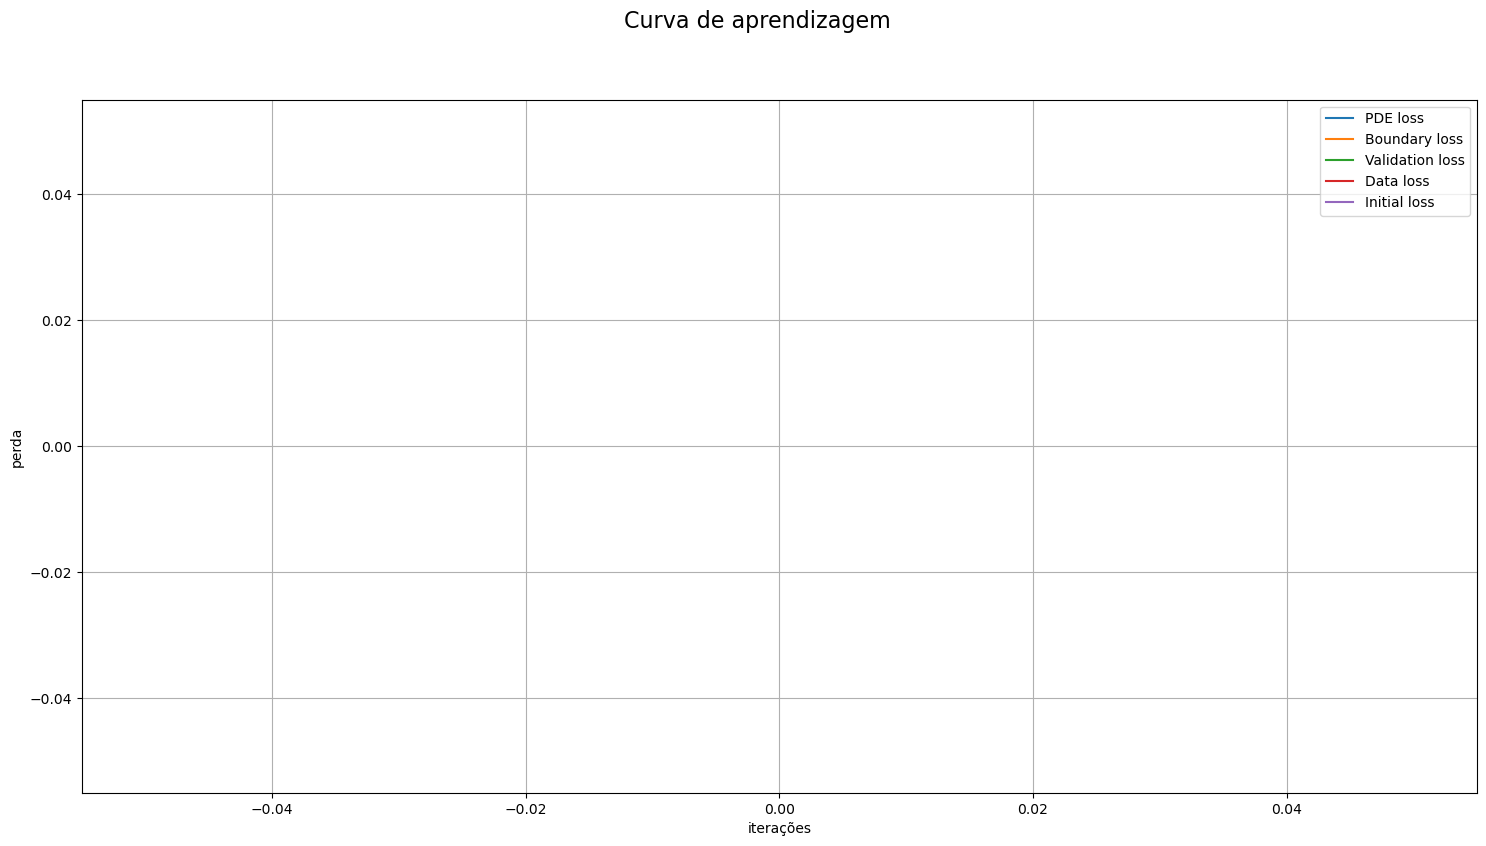

In [25]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[18, 9])

fig.suptitle("Curva de aprendizagem", fontsize=16)

# Plotango 3D
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel("iterações")
ax.set_ylabel("perda")
ax.plot(
    range(len(C_pde_loss_it.cpu().numpy())),
    C_pde_loss_it.cpu().numpy(),
    label="PDE loss",
)

ax.plot(
    range(len(C_boundary_loss_it.cpu().numpy())),
    C_boundary_loss_it.cpu().numpy(),
    label="Boundary loss",
)

ax.plot(
    range(len(val_loss_it.cpu().numpy())),
    val_loss_it.cpu().numpy(),
    label="Validation loss",
)

ax.plot(
    range(len(C_data_loss_it.cpu().numpy())),
    C_data_loss_it.cpu().numpy(),
    label="Data loss",
)

ax.plot(
    range(len(C_initial_loss_it.cpu().numpy())),
    C_initial_loss_it.cpu().numpy(),
    label="Initial loss",
)
# ax.set_yscale("log")
ax.grid()
ax.legend()

plt.show()

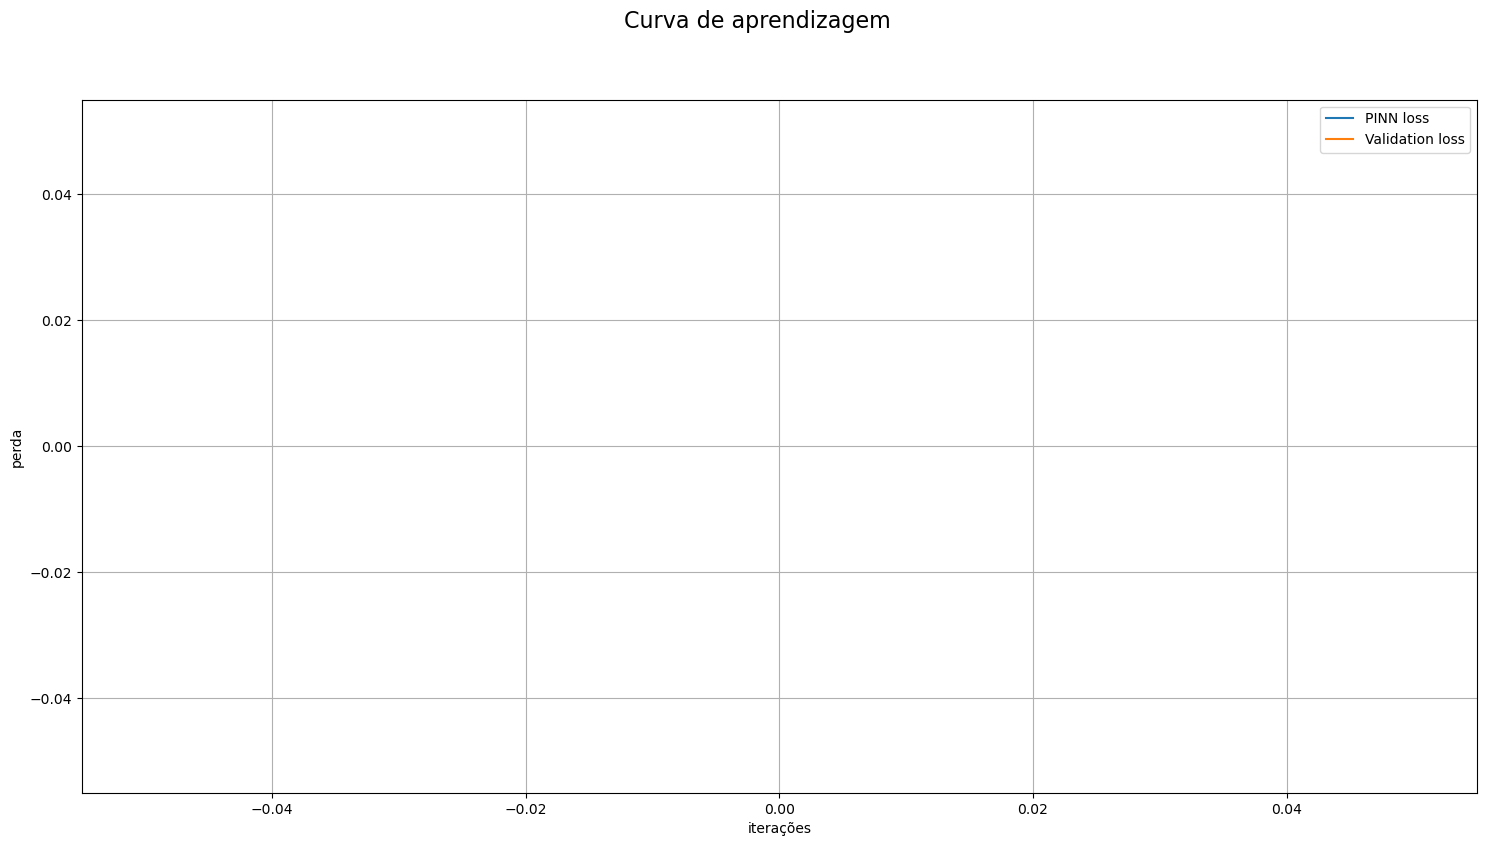

In [26]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[18, 9])

fig.suptitle("Curva de aprendizagem", fontsize=16)

# Plotango 3D
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel("iterações")
ax.set_ylabel("perda")

ax.plot(
    range(len(C_initial_loss_it.cpu().numpy())),
    C_initial_loss_it.cpu().numpy()
    + C_pde_loss_it.cpu().numpy()
    + C_boundary_loss_it.cpu().numpy()
    + C_data_loss_it.cpu().numpy(),
    label="PINN loss",
)
ax.plot(
    range(len(val_loss_it.cpu().numpy())),
    val_loss_it.cpu().numpy(),
    label="Validation loss",
)
# ax.set_yscale("log")
ax.grid()
ax.legend()

plt.show()

## Saving model weights and biases

In [27]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
0.weight 	 torch.Size([32, 7])
0.bias 	 torch.Size([32])
2.weight 	 torch.Size([32, 32])
2.bias 	 torch.Size([32])
4.weight 	 torch.Size([32, 32])
4.bias 	 torch.Size([32])
6.weight 	 torch.Size([32, 32])
6.bias 	 torch.Size([32])
8.weight 	 torch.Size([2, 32])
8.bias 	 torch.Size([2])


In [28]:
import os

cwd = os.getcwd()

torch.save(model.state_dict(), cwd + "/nn_parameters/" + arch_str + ".pt")

In [29]:
import os

cwd = os.getcwd()

model = generate_model(arch_str).to(device)

model.load_state_dict(
    torch.load(cwd + "/nn_parameters/" + arch_str + ".pt", weights_only=True)
)

model.eval()

Sequential(
  (0): Linear(in_features=7, out_features=32, bias=True)
  (1): Tanh()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): Tanh()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): Tanh()
  (6): Linear(in_features=32, out_features=32, bias=True)
  (7): GELU(approximate='none')
  (8): Linear(in_features=32, out_features=2, bias=True)
)

In [30]:
from fvm_model_parallel import cu_solve_pde
import math
from numba import cuda

speed_up = []

for i in range(33):

    start = time.time()

    # Definindo número de threads e blocos para cuda

    threadsperblock = (size_x, size_y)
    blockspergrid_x = math.ceil(size_x / threadsperblock[0])
    blockspergrid_y = math.ceil(size_y / threadsperblock[1])
    blockspergrid = (blockspergrid_x, blockspergrid_y)

    # Inicializando as matrizes para concentrações de neutrófilos (Cn) e bactérias (Cb)

    Cb_buf_0 = cuda.to_device(np.zeros((size_x, size_y)))
    Cn_buf_0 = cuda.to_device(np.zeros((size_x, size_y)))

    # This extra array is used for synchronization purposes

    Cb_buf_1 = cuda.device_array_like(Cb_buf_0)
    Cn_buf_1 = cuda.device_array_like(Cn_buf_0)

    # Matrizes para armazenar as concentrações em cada passo de tempo
    Cb_final_device = cuda.to_device(np.zeros((size_t, size_x, size_y)))
    Cn_final_device = cuda.to_device(np.zeros((size_t, size_x, size_y)))

    cu_solve_pde[threadsperblock, blockspergrid](
        Cb_buf_0,
        Cn_buf_0,
        Cb_buf_1,
        Cn_buf_1,
        Cb_final_device,
        Cn_final_device,
        size_t,
        size_x,
        size_y,
        h,
        k,
        Db,
        Dn,
        phi,
        cb,
        lambd_nb,
        mi_n,
        lambd_bn,
        y_n,
        Cn_max,
        X_nb,
    )

    Cb_host = np.empty(shape=Cb_final_device.shape, dtype=Cb_final_device.dtype)
    Cb_final_device.copy_to_host(Cb_host)

    Cn_host = np.empty(shape=Cn_final_device.shape, dtype=Cn_final_device.dtype)
    Cn_final_device.copy_to_host(Cn_host)

    end = time.time()

    cuda_time = end - start

    start = time.time()

    mesh = torch.cat([t_tc, x_tc, y_tc], dim=1)

    with torch.no_grad():
        Cl_pinn_device, Cp_pinn_device = model(mesh).split(1, dim=1)

    Cl_pinn = Cl_pinn_device.cpu().detach().numpy()
    Cp_pinn = Cp_pinn_device.cpu().detach().numpy()

    end = time.time()

    pinn_time = end - start

    speed_up.append(cuda_time / pinn_time)

TypeError: Signature mismatch: 21 argument types given, but function takes 25 arguments

In [ ]:
mean_speed_up = np.mean(speed_up)
std_speed_up = np.std(speed_up)

rmse = np.mean(
    [
        ((Cl_p[0] - Cl_f) ** 2 + (Cp_p[0] - Cp_f) ** 2) ** 0.5
        for Cl_p, Cp_p, Cl_f, Cp_f in zip(
            Cl_pinn, Cp_pinn, Cn_fdm.flatten(), Cb_fdm.flatten()
        )
    ]
)

max_ae = np.max(
    [
        [((Cl_p[0] - Cl_f) ** 2) ** 0.5, ((Cp_p[0] - Cp_f) ** 2) ** 0.5]
        for Cl_p, Cp_p, Cl_f, Cp_f in zip(
            Cl_pinn, Cp_pinn, Cn_fdm.flatten(), Cb_fdm.flatten()
        )
    ]
)

In [ ]:
output = {
    "rmse": rmse,
    "max_ae": max_ae,
    "mean_speed_up": mean_speed_up,
    "std_speed_up": std_speed_up,
    "Cl_pinn": Cl_pinn,
    "Cp_pinn": Cp_pinn,
}

In [ ]:
print("Erro absoluto médio", rmse)
print("Erro absoluto máximo", max_ae)
print("Speed Up: {} +/-{}".format(mean_speed_up, std_speed_up))

In [ ]:
speed_up

In [ ]:
Cl_pinn_np = Cl_pinn.reshape(size_t, size_x, size_y)
Cp_pinn_np = Cp_pinn.reshape(size_t, size_x, size_y)

In [ ]:
x = np.linspace(x_dom[0], x_dom[1], num=size_x, endpoint=True)
y = np.linspace(y_dom[0], y_dom[1], num=size_y, endpoint=True)
t = np.linspace(t_dom[0], t_dom[1], num=size_t, endpoint=True)

X, Y = np.meshgrid(x, y)

time_plot = np.linspace(0, len(t) - 1, num=5, endpoint=True, dtype=int)

fig = plt.figure(figsize=[6 * len(time_plot), 14])

fig.suptitle("Resposta imunológica a patógenos", fontsize=16)

for i, time_inst in enumerate(time_plot):
    # Plotango 3D
    ax = fig.add_subplot(4, len(time_plot), i + 1)

    vmin = np.min(Cp_pinn_np)
    vmax = np.max(Cp_pinn_np)

    contour = ax.contourf(
        X,
        Y,
        Cp_pinn_np[time_inst],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title("Con. de bactérias em t={}".format(t[time_inst]))
    ax.set_xlabel("tempo")
    ax.set_ylabel("cond. inicial")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

for i, time_inst in enumerate(time_plot):
    # Plotango 3D
    ax = fig.add_subplot(4, len(time_plot), i + len(time_plot) + 1)

    vmin = np.min(Cl_pinn_np)
    vmax = np.max(Cl_pinn_np)

    contour = ax.contourf(
        X,
        Y,
        Cl_pinn_np[time_inst],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title("Con. de bactérias em t={}".format(t[time_inst]))
    ax.set_xlabel("tempo")
    ax.set_ylabel("cond. inicial")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

for i, it in enumerate(time_plot):
    # Plotango 3D
    ax = fig.add_subplot(4, len(time_plot), i + len(time_plot) * 2 + 1)

    vmin = np.min(Cb_fdm)
    vmax = np.max(Cb_fdm)

    contour = ax.contourf(
        X,
        Y,
        Cb_fdm[it],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title("Con. de bactérias em t={}".format(t[it]))
    ax.set_xlabel("tempo")
    ax.set_ylabel("cond. inicial")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

for i, it in enumerate(time_plot):
    # Plotango 3D
    ax = fig.add_subplot(4, len(time_plot), i + len(time_plot) * 3 + 1)

    vmin = np.min(Cn_fdm)
    vmax = np.max(Cn_fdm)

    contour = ax.contourf(
        X,
        Y,
        Cn_fdm[it],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title("Con. de bactérias em t={}".format(t[it]))
    ax.set_xlabel("tempo")
    ax.set_ylabel("cond. inicial")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

plt.show()